In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import pickle

## Carga de datos train

In [2]:
df = pd.read_csv("../data/train/train.csv")
df.head()

,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Diagnosis
0,4.862270,2.471408,0,0,9.788456,0
1,28.316033,5.021810,0,0,2.873132,0
2,27.204428,3.819500,1,0,2.150132,0
3,6.177355,0.036686,0,0,2.570051,1
4,6.847389,9.246352,1,0,1.814942,1


In [3]:
X_train = df.drop(["Diagnosis"], axis=1)
y_train = df["Diagnosis"]

## Entrenamiento de modelos

### Prueba con Gradient Boosting Classifier y GridSearch

In [ ]:
gb = GradientBoostingClassifier(random_state=11)
parametros = {"n_estimators": [100, 200, 400, 600, 800], "learning_rate": [0.3, 0.5, 0.6, 0.8], "max_depth": [2, 3, 4]} # parametros GS

gs_gb = GridSearchCV(estimator=gb, param_grid=parametros, scoring="recall", cv=3, verbose=3, n_jobs=-1) # modelo base, parametros, nuestro scoring en recall y 3 cv
gs_gb.fit(X_train, y_train) # entrenamiento del modelo

print("Mejor estimator:", gs_gb.best_estimator_) # mejor modelo con parametros
print("Mejor parametro:", gs_gb.best_params_) # los mejores parametros
print("Mejor recall:", gs_gb.best_score_) # el mejor resultado de recall

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Mejor estimator: GradientBoostingClassifier(learning_rate=0.3, max_depth=2, random_state=11)
Mejor parametro: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Mejor recall: 0.9026402640264027


## Carga de datos test

In [5]:
df_test = pd.read_csv("../data/test/test.csv")

In [6]:
X_test = df_test.drop(["Diagnosis"], axis=1)
y_test = df_test["Diagnosis"]

In [ ]:
pred_gb = gs_gb.best_estimator_.predict(X_test) # predecimos con la parte de X_test
scores = gs_gb.best_estimator_.predict_proba(X_test)[:,1] # guardamos en scores la predict proba para el AUC

print("Recall:", recall_score(y_test, pred_gb)) # visualizar el recall
print("Accuracy:", accuracy_score(y_test, pred_gb)) # visualizar el accuracy
print("AUC:", roc_auc_score(y_test, scores)) # visualizar el roc_auc
print("CM:", confusion_matrix(y_test, pred_gb)) # visualizar la matriz de confusión
print("Report:", classification_report(y_test, pred_gb)) # visualizar reporte completo

Recall: 0.961038961038961
Accuracy: 0.9534883720930233
AUC: 0.9599214191605497
CM: [[262  14]
 [  6 148]]
Report:               precision    recall  f1-score   support

           0       0.98      0.95      0.96       276
           1       0.91      0.96      0.94       154

    accuracy                           0.95       430
   macro avg       0.95      0.96      0.95       430
weighted avg       0.95      0.95      0.95       430



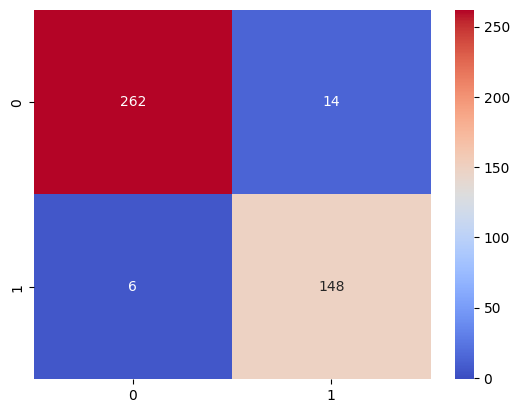

In [ ]:
# Mapa de calor de la matriz de confusión para mejor visualización de la misma

sns.heatmap(confusion_matrix(y_test, pred_gb), annot=True, vmin=-1, fmt="d", cmap="coolwarm");

Visualización de un Dataframe con la importancia que el modelo le da a las variables

In [9]:
df_importances_gbcl = pd.DataFrame({"Columna": gs_gb.best_estimator_.feature_names_in_, "Importancia": gs_gb.best_estimator_.feature_importances_})
df_importances_gbcl.sort_values("Importancia", ascending=False)

,Columna,Importancia
0,MMSE,0.282304
1,FunctionalAssessment,0.281813
4,ADL,0.207769
2,MemoryComplaints,0.129720
3,BehavioralProblems,0.098394


Guardado de modelo con pickle

In [10]:
pickle.dump(gs_gb.best_estimator_, open("../models/05_modelo_GradientBoost.pkl", "wb"))